In [43]:
import pyfits
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn as skl
import sklearn.neighbors.kde as kde

In [21]:
tru_hdulist = pyfits.open('Buzzard_v1.1_truth.147.fit')

In [22]:
tru_hdulist.info()

Filename: Buzzard_v1.1_truth.147.fit
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       4   ()              
1                BinTableHDU    113   5022692R x 48C   [K, J, J, 5E, 5E, 5E, 5E, 5E, 5E, 5E, E, E, E, J, E, E, J, E, I, E, E, 2E, E, E, E, E, 5E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, 2E, E, E]   


In [23]:
tru_hdulist[1].header

XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.11           
BITPIX  =                    8 /Required value                                  
NAXIS   =                    2 /Required value                                  
NAXIS1  =                  330 /Number of bytes per row                         
NAXIS2  =              5022692 /Number of rows                                  
PCOUNT  =                    0 /Normally 0 (no varying arrays)                  
GCOUNT  =                    1 /Required value                                  
TFIELDS =                   48 /Number of columns in table                      
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
COMMENT                                                                         
COMMENT  *** Column names **

In [26]:
tru_data = tru_hdulist[1].data

In [27]:
tru_cols

ColDefs(
    name = 'ID'; format = 'K'
    name = 'INDEX'; format = 'J'
    name = 'ECATID'; format = 'J'
    name = 'COEFFS'; format = '5E'
    name = 'TMAG'; format = '5E'
    name = 'OMAG'; format = '5E'
    name = 'FLUX'; format = '5E'
    name = 'IVAR'; format = '5E'
    name = 'OMAGERR'; format = '5E'
    name = 'AMAG'; format = '5E'
    name = 'RA'; format = 'E'
    name = 'DEC'; format = 'E'
    name = 'Z'; format = 'E'
    name = 'HALOID'; format = 'J'
    name = 'RHALO'; format = 'E'
    name = 'M200'; format = 'E'
    name = 'NGALS'; format = 'J'
    name = 'R200'; format = 'E'
    name = 'CENTRAL'; format = 'I'
    name = 'TRA'; format = 'E'
    name = 'TDEC'; format = 'E'
    name = 'EPSILON'; format = '2E'
    name = 'GAMMA1'; format = 'E'
    name = 'GAMMA2'; format = 'E'
    name = 'KAPPA'; format = 'E'
    name = 'MU'; format = 'E'
    name = 'LMAG'; format = '5E'
    name = 'MAG_U'; format = 'E'
    name = 'SIZE'; format = 'E'
    name = 'SIZE_SUBARU'; format = 'E'
  

In [28]:
obs_hdulist = pyfits.open('Buzzard_v1.1.147.fit')

In [29]:
obs_hdulist.info()

Filename: Buzzard_v1.1.147.fit
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       4   ()              
1                BinTableHDU     87   5022692R x 35C   [K, J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   


In [30]:
obs_hdulist[1].header

XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.11           
BITPIX  =                    8 /Required value                                  
NAXIS   =                    2 /Required value                                  
NAXIS1  =                  144 /Number of bytes per row                         
NAXIS2  =              5022692 /Number of rows                                  
PCOUNT  =                    0 /Normally 0 (no varying arrays)                  
GCOUNT  =                    1 /Required value                                  
TFIELDS =                   35 /Number of columns in table                      
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
COMMENT                                                                         
COMMENT  *** Column names **

In [31]:
obs_data = hdulist[1].data

In [42]:
print(obs_data['PHOTOZ_GAUSSIAN'][:100])

[ 0.20040531  0.17424706  0.19135329  0.04817338  0.11722817  0.16997053
  0.01596476  0.12242857  0.07001662  0.12594463  0.10058986  0.15153506
  0.15089917 -0.01448094  0.07819025  0.19339602  0.01279342  0.06470924
  0.19571778  0.15605633  0.09771299  0.14777657  0.04240934  0.15940323
  0.13170758  0.01252273  0.15632254  0.08886777  0.24016573  0.11382212
  0.06866187  0.08184443  0.07759178  0.08845558  0.07609442  0.08231536
  0.06347945  0.04841309  0.07242226  0.0932597   0.16160072  0.0375611
  0.0879536   0.12019446  0.12653403  0.07297637  0.17693441  0.12905337
  0.07086489  0.11078633  0.13166381  0.09513422  0.09640434  0.13629737
  0.14631319  0.13175561  0.10186042  0.037319    0.11001825  0.18129283
  0.12140925  0.11755336 -0.00176905  0.09284056  0.09236023  0.01032907
  0.13290706  0.10499009  0.09228314  0.12347526  0.1256367   0.11920968
  0.10477524  0.16269547  0.16621858  0.17071028  0.16833748  0.12771255
  0.12063693  0.01345479  0.03952005  0.03859562  0.

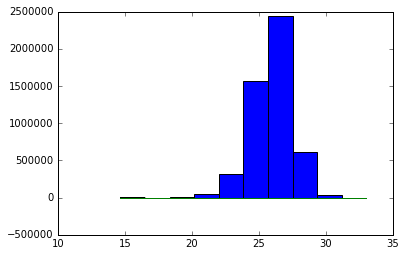

In [70]:
X = tru_data['MAG_U']#[:, np.newaxis]
#X.reshape(-1,1)
#print(np.shape(X))
kde_test = kde.KernelDensity(kernel='gaussian', bandwidth=1.).fit(X.reshape(-1,1))
X_plot = np.linspace(np.min(X), np.max(X), 1000)[:, np.newaxis]
res = kde_test.score_samples(X_plot)
# print(np.shape(X_plot),np.shape(res))

plt.hist(X)

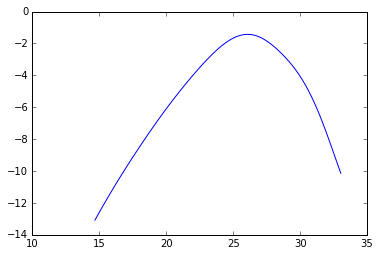

In [71]:
plt.plot(X_plot[:, 0], res)

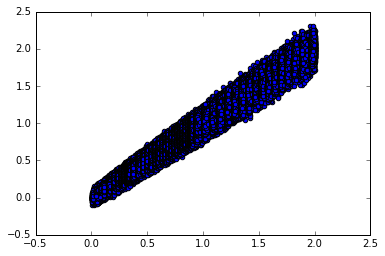

In [67]:
plt.scatter(tru_data['Z'],obs_data['PHOTOZ_GAUSSIAN'])